# ANALISIS EXPLORATORIO

## 0. Importación de Librerías

In [407]:
import pandas as pd 
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [408]:
# Crear tabla unificada con análisis de valores nulos
def analisis_valores_nulos(df):
    # Calcular estadísticas de valores nulos
    valores_nulos = df.isnull().sum()
    porcentaje_nulos = (valores_nulos / len(df)) * 100
    total_registros = len(df)
    registros_validos = total_registros - valores_nulos
    
     # Obtener tipos de datos
    tipos_datos = df.dtypes
    
    # Crear DataFrame con los resultados
    tabla_nulos = pd.DataFrame({
        'Columna': valores_nulos.index,
        'Tipo_Variable': tipos_datos.values,
        'Valores_Nulos': valores_nulos.values,
        'Registros_Validos': registros_validos.values,
        'Porcentaje_Nulos': porcentaje_nulos.values
    })
    
    # Ordenar por porcentaje de valores nulos de forma descendente
    tabla_nulos = tabla_nulos.sort_values('Porcentaje_Nulos', ascending=False)
    
    # Resetear índice
    tabla_nulos = tabla_nulos.reset_index(drop=True)
    
    return tabla_nulos

## 1. Carga y Exploración del Dataset

In [409]:
# Carga del dataset

parquet_url = 'https://raw.githubusercontent.com/tuliorozco/applied-statistics/3f8a3143ae31bf21bb6575e84a8d1e9d61317e82/data/vehicles.parquet'
df = pd.read_parquet(parquet_url, engine='auto')

### 1.1. Vista General de los Datos

In [410]:
# Eliminación de columnas no relevantes para el ejercicio.

df = df.drop(columns=['title_status','region','state','posting_date'], axis=1)

# Visualizacieon del encabezado del dataset
df.head()


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
0,6000,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [411]:
df.tail()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type
426875,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,other,fwd,sedan
426876,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,other,fwd,sedan
426877,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,other,NaN,hatchback
426878,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,other,fwd,sedan
426879,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,other,rwd,coupe


De la visualización del encabezado y el final del dataframe, se evidencia que hay observaciones que cuentan únicamente con dato en la columna *price*. A continuación, se presenta un resumen del conjunto de datos. Así mismo, en las tablas se revelan otros aspectos que deben ser normalizados como son: cifras decimales en los campos *year* y *odometer* y la eliminación del texto en la característica *cylinders*, dejando únicamente el valor numérico en el atributo.

In [412]:
# Usar la función
tabla_resultados = analisis_valores_nulos(df)

# Mostrar la tabla
print("ANÁLISIS DE VALORES NULOS")
print("=" * 90)
print(tabla_resultados.to_string(index=False, float_format='%.2f'))

# Opcional: Mostrar información adicional del dataframe
print(f"\nInformación general:")
print(f"- Dimensiones del DataFrame: {df.shape}")
print(f"- Total de registros: {len(df)}")
print(f"- Total de columnas: {len(df.columns)}")
print(f"- Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

ANÁLISIS DE VALORES NULOS
     Columna Tipo_Variable  Valores_Nulos  Registros_Validos  Porcentaje_Nulos
   cylinders      category         177678             249202             41.62
   condition      category         174104             252776             40.79
       drive      category         130567             296313             30.59
        type      category          92858             334022             21.75
manufacturer      category          17646             409234              4.13
       model        object           5277             421603              1.24
    odometer       float32           4400             422480              1.03
        fuel      category           3013             423867              0.71
transmission      category           2556             424324              0.60
        year       float32           1205             425675              0.28
       price         int64              0             426880              0.00

Información general:
- Di

El anterior resumen, revela que algunos campos tienen una alta proporción de valores nulos/vacíos como es el caso de la variable *cylinders* con un 41.62% de observaciones sin información. Por lo anterior, se procede con la eliminación de todos los registros que presentan valor vacío en cualquiera de los campos.

In [413]:
# Extraer solo los números de la columna cylinders
df['cylinders'] = df['cylinders'].astype(str).str.extract('(\d+)')[0]

# Eliminar decimales (convertir a entero)
df['year'] = df['year'].fillna(0).astype(int)
df['odometer'] = df['odometer'].fillna(0).astype(int)

# Crear nueva columna con la edad del vehículo
current_year = 2025  # Año actual según el contexto
df['vehicle_age'] = current_year - df['year']

df['high_demand'] = (df['price'] > df['price'].median()).astype(int)

# Descartar marcas no asociadas a autos, SUV's 
df = df[~df['manufacturer']
        .str.lower()                # todo en minúsculas
        .str.strip()                 # quitar espacios al inicio y final
        .str.replace('-', ' ')       # guiones → espacios
        .str.replace(r'\s+', ' ', regex=True)  # colapsar espacios múltiples
        .isin(['harley davidson', 'morgan'])]

# Se descartan las observaciones con valor nulo
df = df.dropna()


# se muestra el encabezado del dataframe
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,vehicle_age,high_demand
31,15000,2013,ford,f-150 xlt,excellent,6,gas,128000,automatic,rwd,truck,12,1
32,27990,2012,gmc,sierra 2500 hd extended cab,good,8,gas,68696,other,4wd,pickup,13,1
33,34590,2016,chevrolet,silverado 1500 double,good,6,gas,29499,other,4wd,pickup,9,1
34,35000,2019,toyota,tacoma,excellent,6,gas,43000,automatic,4wd,truck,6,1
35,29990,2016,chevrolet,colorado extended cab,good,6,gas,17302,other,4wd,pickup,9,1


In [414]:
# Se evalúa el final del dataframe.
df.tail()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,vehicle_age,high_demand
426860,39990,2017,infiniti,qx80 sport utility 4d,good,8,gas,41664,automatic,4wd,other,8,1
426866,32990,2016,infiniti,qx80 sport utility 4d,good,8,gas,55612,automatic,rwd,other,9,1
426874,33590,2018,lexus,gs 350 sedan 4d,good,6,gas,30814,automatic,rwd,sedan,7,1
426875,23590,2019,nissan,maxima s sedan 4d,good,6,gas,32226,other,fwd,sedan,6,1
426878,28990,2018,lexus,es 350 sedan 4d,good,6,gas,30112,other,fwd,sedan,7,1


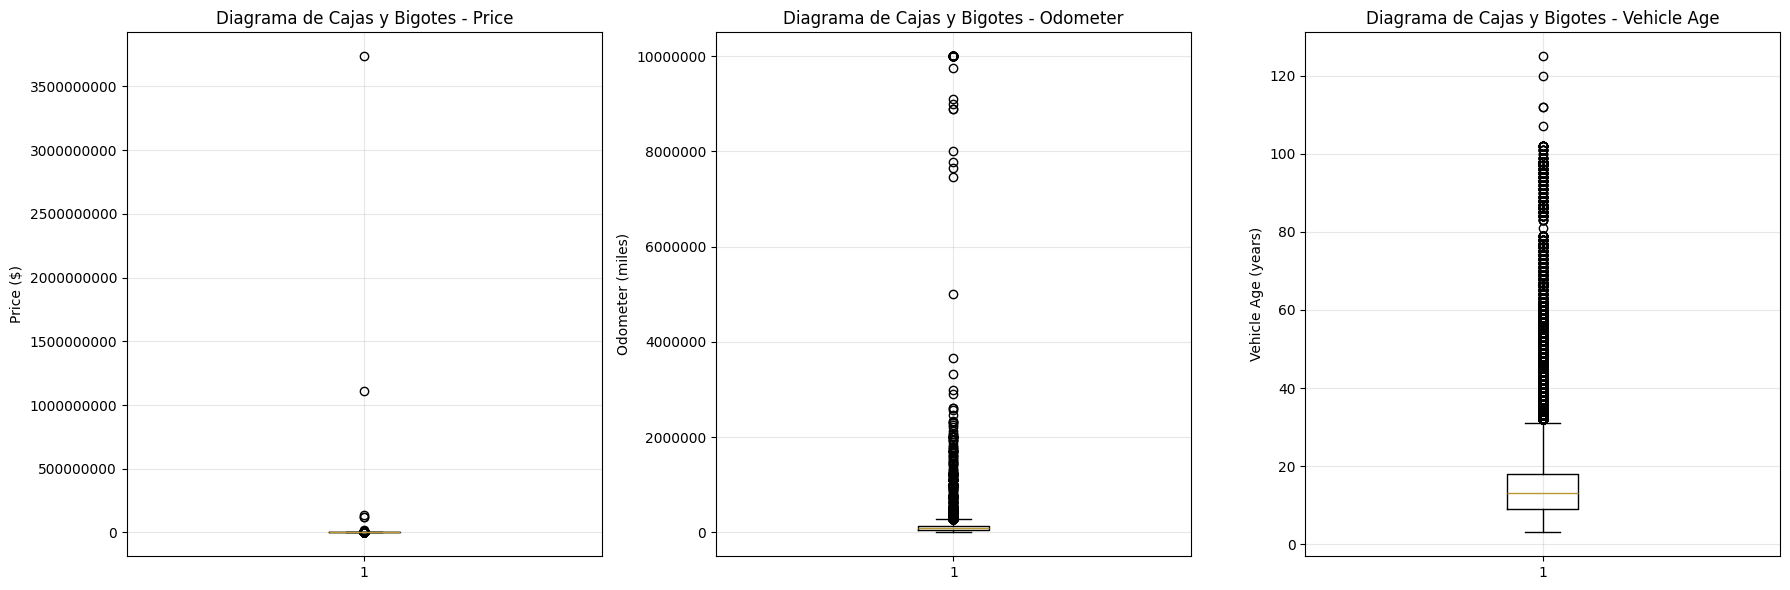

In [415]:
# Configuración de estilo para los gráficos
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con subplots en una fila (1x3) para los 3 diagramas de cajas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Diagrama de cajas para Price
axes[0].boxplot(df['price'])
axes[0].set_title('Diagrama de Cajas y Bigotes - Price')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='y')  # Mostrar valores reales en el eje Y

# Diagrama de cajas para Odometer
axes[1].boxplot(df['odometer'])
axes[1].set_title('Diagrama de Cajas y Bigotes - Odometer')
axes[1].set_ylabel('Odometer (miles)')
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(style='plain', axis='y')  # Mostrar valores reales en el eje Y

# Diagrama de cajas para Vehicle Age
axes[2].boxplot(df['vehicle_age'])
axes[2].set_title('Diagrama de Cajas y Bigotes - Vehicle Age')
axes[2].set_ylabel('Vehicle Age (years)')
axes[2].grid(True, alpha=0.3)
axes[2].ticklabel_format(style='plain', axis='y')  # Mostrar valores reales en el eje Y

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar gráficos
plt.show()

En la figura 1 se puede observar como se distribuyen tres variables importantes en un conjunto de datos de vehículos: el precio, el kilometraje (odómetro) y la edad del vehículo. En cada uno de los diagramas se puede ver que la mayoría de los datos están agrupados en valores relativamente bajos, lo que indica que la mayoría de los vehículos son económicos, tienen poco uso y no son muy antiguos.

Sin embargo, la gráfica tambien revela que hay observaciones extremas, que representan vehículos con precios muy altos, millajes extremos o años de antigüedad inusualmente elevadas. La presencia de estos valores puede influir en los análisis estadísticos o en los modelos de predicción, ya que pueden afectar los resultados si no se manejan adecuadamente.

### 1.2. Tratamiento de Valores Atípicos

Para minimizar el ruido en los datos, el tratamiento a aplicar en las observaciones atípicas será la eliminación. Existen diversos mecanismos para filtrar los outliers y en este caso, se determinarán los límites inferior y superior para la exclusión de la siguiente manera:

$$límite_{inferior} = Q1 - (1.5 * IQR) \\
límite_{superior} = Q3 + (1.5 * IQR)
$$


📊 Filas antes: 130115
📊 Filas después de eliminar outliers: 120973


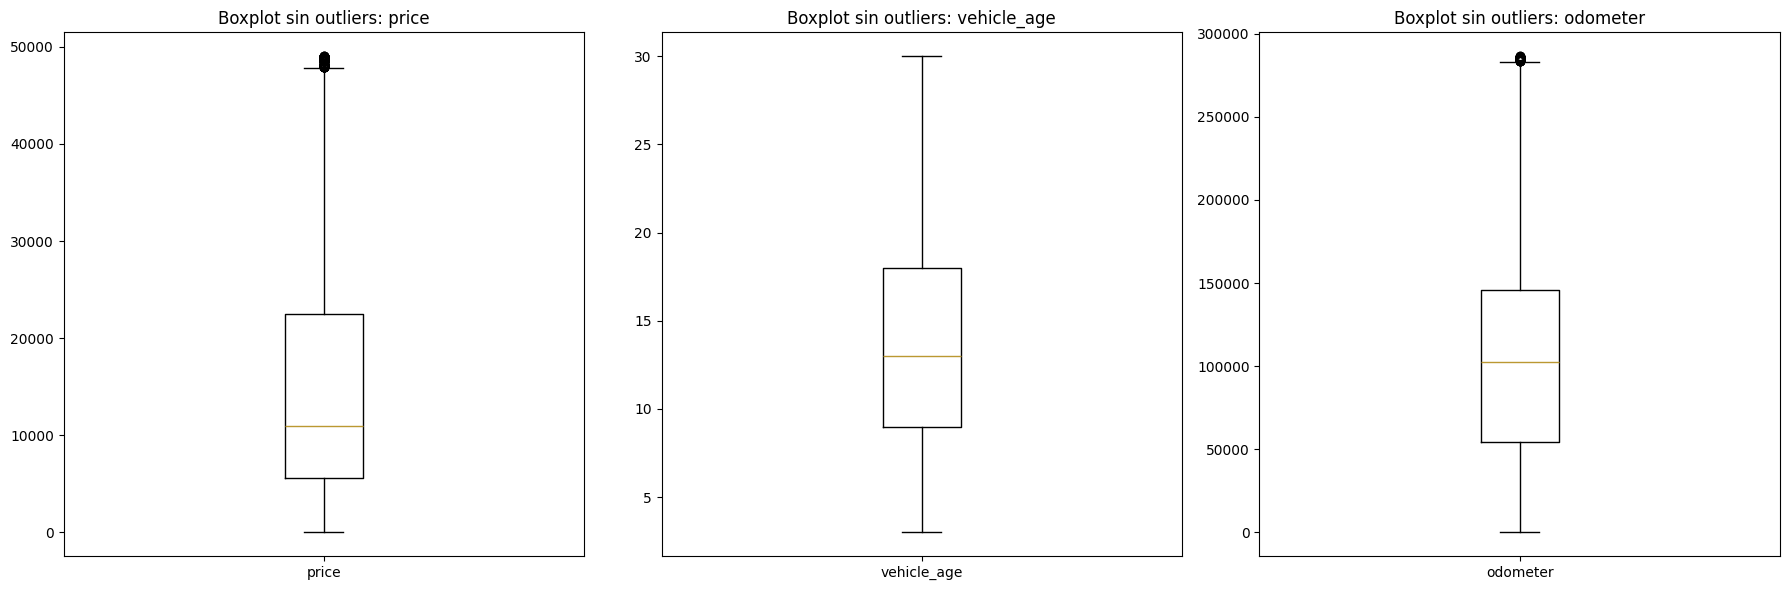

In [416]:
# === 1. Eliminar outliers con IQR ===
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Variables numéricas de tu dataframe
numeric_cols = ["price", "vehicle_age", "odometer"]
df_no_outliers = remove_outliers_iqr(df, numeric_cols)

print(f"📊 Filas antes: {df.shape[0]}")
print(f"📊 Filas después de eliminar outliers: {df_no_outliers.shape[0]}")

# Graficar boxplot sin outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df_no_outliers[col])
    axes[i].set_title(f"Boxplot sin outliers: {col}")
    axes[i].set_xticks([1])
    axes[i].set_xticklabels([col])
    
plt.tight_layout()
plt.show()

El diagrama de *boxplot* de la gráfica 2 muestra las variables precio, edad del vehículo y odómetro, esta vez sin valores atípicos, gracias al tratamiento mediante el método del rango intercuartílico (IQR). Al eliminar los outliers, se obtiene una representación mejor y ajustada de la distribución central de los datos.

En el boxplot del precio, se observa que los valores están concentrados en un rango más estrecho, lo que facilita la identificación de la mediana y la dispersión típica del mercado el cual se concentra en precios bajos. El odómetro muestra una distribución más homogénea del kilometraje de los vehículos. Por su parte, la edad del vehículo se presenta con una variabilidad más controlada, permitiendo una mejor comparación entre unidades.

Este tratamiento por medio del IQR mejora la calidad del análisis estadístico, ya que reduce el sesgo que podrían generar los valores extremos y permite una interpretación más representativa del comportamiento general de los datos.

In [417]:
# Dataframe resumen por el año del vehículo.
summary_stats_by_Year = df_no_outliers.groupby('year').agg({
    'price': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'vehicle_age': ['mean', 'median', 'std', 'min', 'max'],
    'odometer': ['mean', 'median', 'std', 'min', 'max']
}).round(0)

In [418]:
df_no_outliers.shape

(120973, 13)

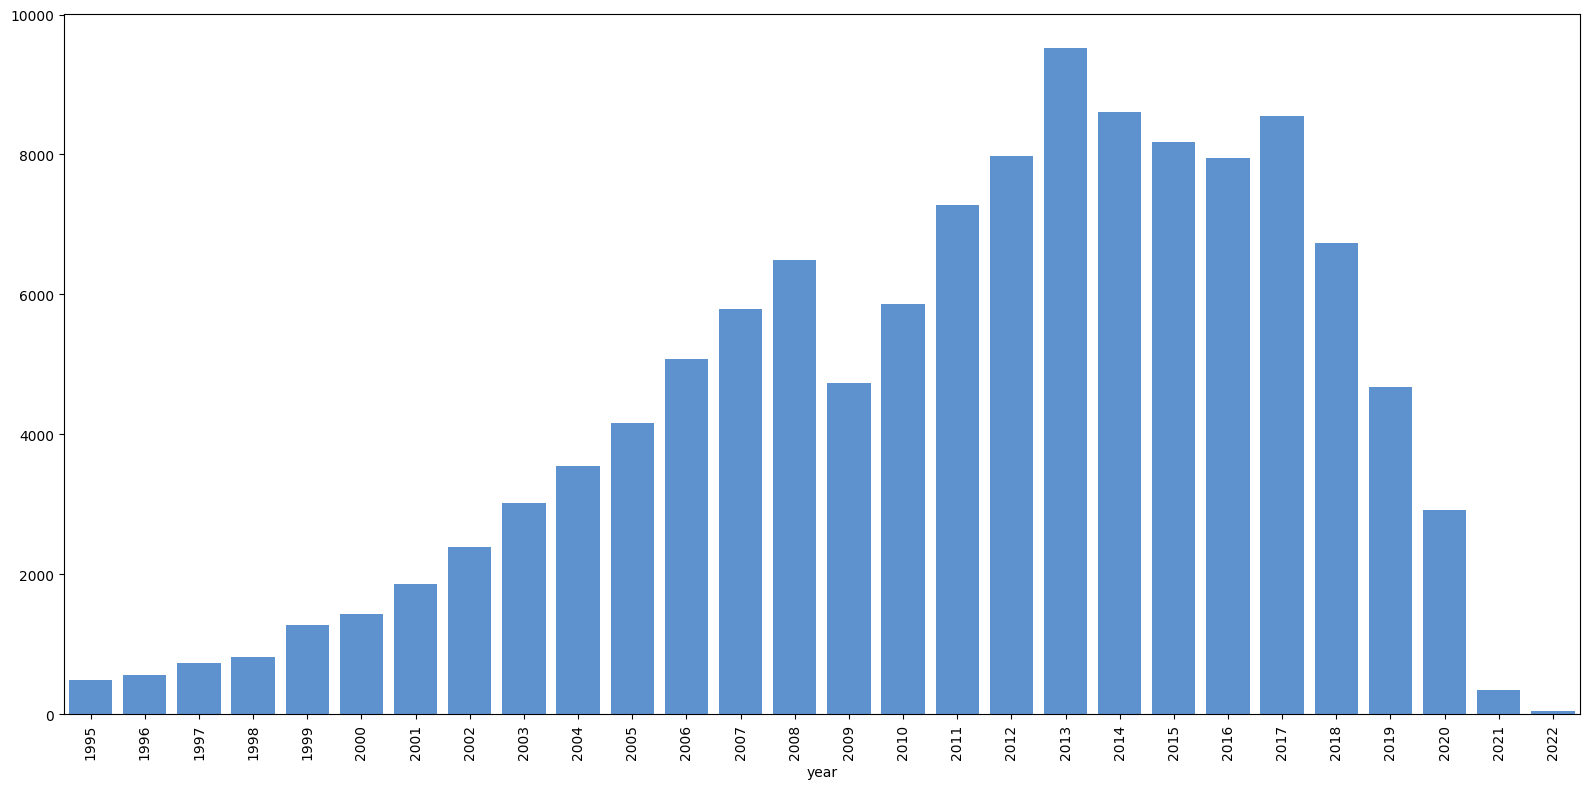

In [427]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
freq_data = summary_stats_by_Year[('price', 'count')]

sns.barplot(x=freq_data.index, y=freq_data.values, 
            color="#4A90E2" , # Azul medio
            ax=ax1)

# Ajustar etiquetas cada 5 años
ax1.set_xticks(range(0, len(freq_data.index), 1))
ax1.set_xticklabels(freq_data.index[::1], rotation=90)

plt.tight_layout()  # Evita recortes
plt.show(block=True)

El gráfico de la figura 3 muestra la distribución de las publicaciones de acuerdo al año del vehículo del dataset filtrado, sin atípicos. El gráfico revela un patrón temporal característico del mercado de vehículos usados, con un crecimiento sostenido desde el año 2000 hasta alcanzar su pico máximo en 2013 con aproximadamente 9,500 vehículos. Esta tendencia ascendente refleja el boom del sector automotriz durante la primera década del 2000, donde años como 2010-2015 concentran la mayor disponibilidad de vehículos en el mercado secundario. Los años previos a 2000 muestran frecuencias muy bajas, lo que es esperable dado que estos vehículos vintage representan una fracción mínima del mercado actual de usados.


A partir de 2014 se observa una disminución gradual en las frecuencias, estabilizándose en rangos de 3,000-4,000 vehículos anuales, con una caída más pronunciada en los años 2020-2022. Esta tendencia descendente en años recientes tiene explicaciones lógicas: los vehículos muy nuevos (2020+) aún no han ingresado masivamente al mercado de usados debido a su corto ciclo de vida, además del impacto de factores externos como la pandemia COVID-19 y la escasez global de semiconductores que afectaron la producción automotriz. Este patrón confirma que el dataset representa adecuadamente la realidad del mercado, donde los vehículos de 8-15 años de antigüedad dominan las transacciones de vehículos usados.

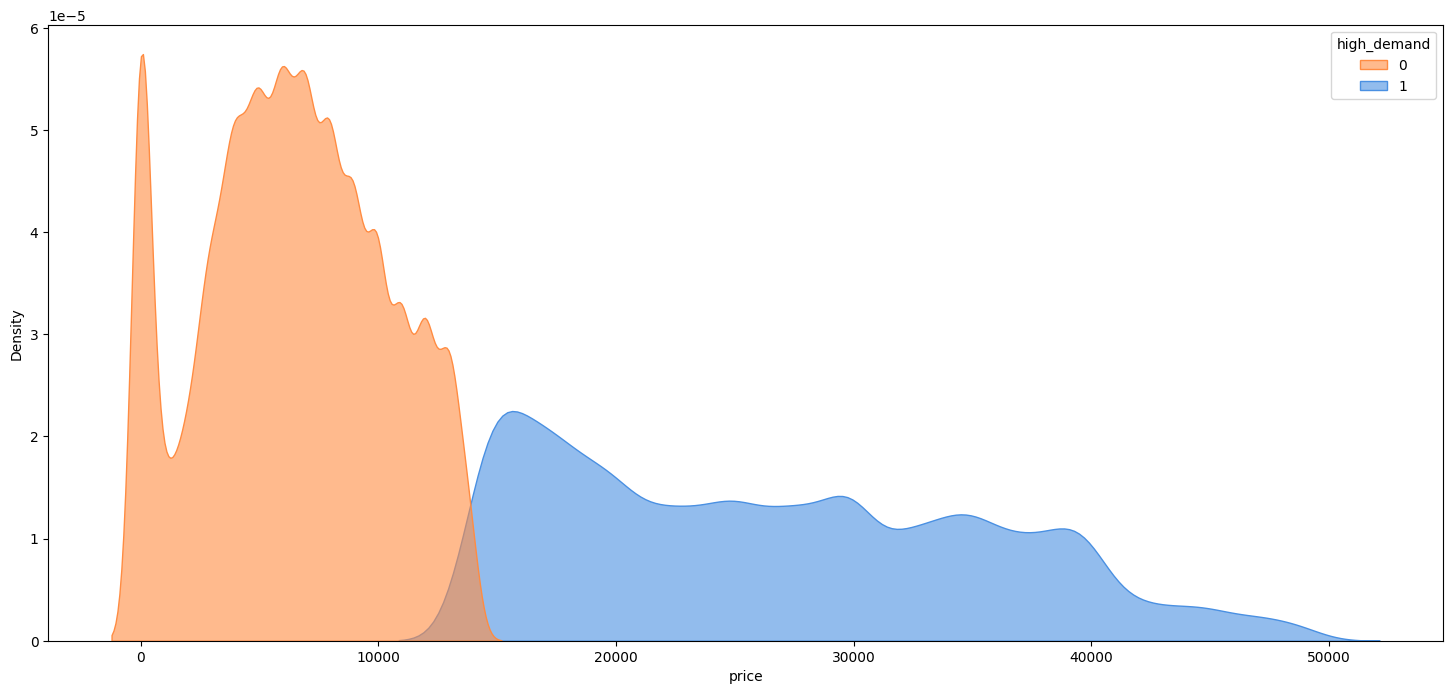

(<Axes: xlabel='price', ylabel='Density'>, None)

In [433]:
plt.figure(figsize=(18, 8))
sns.kdeplot(data=df_no_outliers, x='price', hue='high_demand', 
            palette={0: "#FF8C42", 1: "#4A90E2"},
            fill=True, alpha=0.6), plt.show()




El gráfico 4 de densidad revela una clara segmentación del mercado basada en la demanda, con distribuciones de precios marcadamente diferenciadas. Los vehículos de baja demanda (naranja) presentan una distribución altamente concentrada en el segmento de precios bajos, con picos pronunciados entre $0-$7,000 y una cola que se extiende hasta aproximadamente $15,000, sugiriendo una rápida depreciación y menor retención de valor. En contraste, los vehículos de alta demanda (azul) muestran una distribución más plana y extendida hacia rangos superiores, con densidad relativamente uniforme desde $10,000 hasta $40,000+, indicando mayor estabilidad en la retención de valor. La minimal superposición entre ambas distribuciones confirma que el nivel de demanda es un predictor robusto del rango de precios, donde los vehículos de alta demanda mantienen valoraciones significativamente superiores y menor volatilidad en sus precios de mercado.

In [420]:
profile = ProfileReport(df_no_outliers)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 72.65it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

El anterior resumen, generado con la función `ProfileReport` de la librería `ydata_profiling` permite tener una vista general de cada una de los atributos que conforman el dataset.  Entre otros aspectos, llama la atención de la cantidad de observaciones con valor 0 en el campo *price* (5103 filas). En lo que respecta a la columna *manufacturer* se destaca que los 5 primeros fabricantes con mayor participación son, en orden descendente: *ford, chevrolet, toyota, honda y nissan*. Sobre la caractereistica *model*, la nube de datos evidencia una alta participación de *silverdado, ram-1500, ford f-150, jeep wrangler*, entre otros.

In [423]:
summary_stats_by_Manufacturer = df_no_outliers.groupby('manufacturer').agg({
    'price': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'vehicle_age': ['mean', 'median', 'std', 'min', 'max'],
    'odometer': ['mean', 'median', 'std', 'min', 'max']
}).round(0)

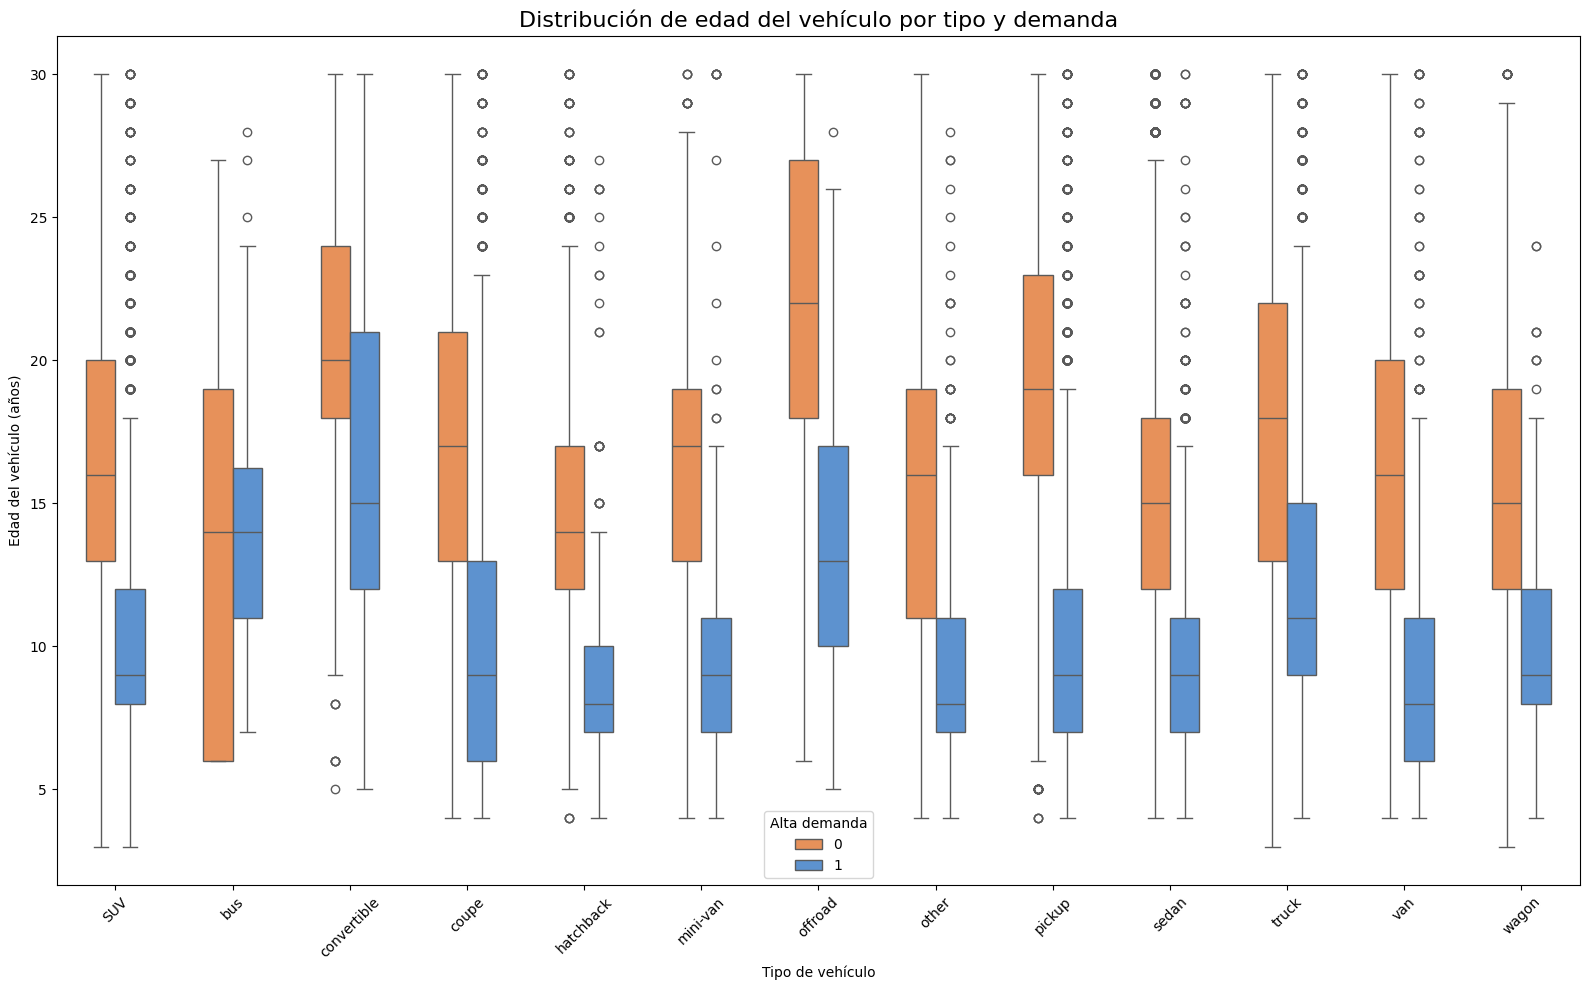

In [429]:
plt.figure(figsize=(16, 10))
sns.boxplot(
    data=df_no_outliers,
    x="type",
    y="vehicle_age",
    hue="high_demand",
    width=0.5,
    showfliers=True,  # Cambia a False si quieres ocultar los outliers
    palette={0: "#FF8C42", 1: "#4A90E2"}  # 0 = naranja, 1 = azul
)

plt.title("Distribución de edad del vehículo por tipo y demanda", fontsize=16)
plt.xlabel("Tipo de vehículo")
plt.ylabel("Edad del vehículo (años)")
plt.xticks(rotation=45)
plt.legend(title="Alta demanda")
plt.tight_layout()
plt.show()

El análisis bivariado de la figura 6, exhibe una relación inversa significativa entre la edad del vehículo y su nivel de demanda en el mercado de usados. Los vehículos de alta demanda (categoría 1, en azul) presentan consistentemente distribuciones de edad más bajas, con medianas que oscilan entre 8-12 años, mientras que los vehículos de baja demanda (categoría 0, en naranja) muestran medianas superiores a 15-20 años. Esta tendencia se mantiene transversalmente en todos los tipos de vehículos, siendo particularmente evidente en categorías como offroad, sedan y truck, donde la diferencia entre medianas supera los 5-8 años. La presencia abundante de outliers en ambas categorías sugiere heterogeneidad en los patrones de depreciación y preferencias del consumidor, confirmando que la edad constituye un factor determinante en la percepción de valor y deseabilidad en el mercado secundario automotriz, independientemente del tipo de vehículo.